In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05b Toy Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05b Toy Dataset Benchmarker.ipynb"
dataset_name = "directed circle"
sigma = "automatic"
flow_strength = 1
smoothness_weight = 0
flow_neighbor_loss_weight = 0
contrastive_flow_loss_weight = 0
contrastive_loss_weight = 1
reconstruction_loss_weight = 1
diffdist_weight = 0
num_neighbors = 5

# Set Up

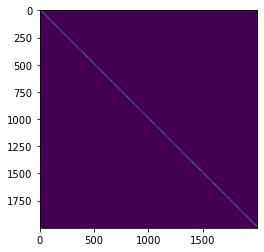

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, directed_circle
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorFieldV2, neighborhood_collate_function
from torch.utils.data import DataLoader
# choose correct dataset
num_nodes = 2000
if dataset_name == "double helix":
    X, flow, labels = double_helix(num_nodes=num_nodes)
elif dataset_name == "noisy double helix":
    X, flow, labels = double_helix(num_nodes=num_nodes, noise=0.5)
elif dataset_name == "branch":
    X, flow, labels = directed_sinh_branch(num_nodes=num_nodes)
elif dataset_name == "directed circle":
    X, flow, labels = directed_circle(num_nodes=num_nodes)
else:
    raise NotImplementedError
# build dataset
ds = ManifoldWithVectorFieldV2(X, flow, labels, n_neighbors=int(num_nodes/20))
dataloader = DataLoader(ds, batch_size=64, shuffle=True, collate_fn=neighborhood_collate_function)

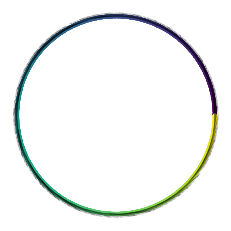

In [ ]:
# visualize figure
from FRED.datasets import plot_origin_3d, plot_directed_2d
# if figure is 3d or 2d
if np.sum(np.abs(X[:,2])) == 0:
    plot_directed_2d(X,flow,labels,minimal=True)
else:
    mask_prob = 1
    num_nodes = X.shape[0]
    alpha_points, alpha_arrows = (0.1, 1) if labels is None else (1, 0.1)
    mask = np.random.rand(num_nodes) > mask_prob
    fig = plt.figure(dpi=400, figsize=(8,8))
    ax = fig.add_subplot(projection="3d",)
    plot_origin_3d(
        ax,
        xlim=[X[:, 0].min(), X[:, 0].max()],
        ylim=[X[:, 1].min(), X[:, 1].max()],
        zlim=[X[:, 2].min(), X[:, 2].max()],
        )
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker=".", c=labels, cmap="viridis", alpha=alpha_points)
    ax.quiver(
        X[mask, 0],
        X[mask, 1],
        X[mask, 2],
        flow[mask, 0],
        flow[mask, 1],
        flow[mask, 2],
        alpha=0.4,
        length=0.4,
        normalize=False,
    )
# ax.axis('off')
# ax.grid(False)
# lim = np.max(np.linalg.norm(X, axis=1))
# print("lim is",lim)
# ax.axes.set_xlim3d(left=-lim, right=lim)
# ax.axes.set_ylim3d(bottom=-lim, top=lim)
# ax.axes.set_zlim3d(bottom=-lim, top=lim)
plt.show()

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=1,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": reconstruction_loss_weight,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
            "contrastive loss": contrastive_loss_weight,
        }
visualization_functions = [
    visualize_points,
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title, learning_rate=1e-4)

  0%|                                               | 0/300 [00:00<?, ?it/s]

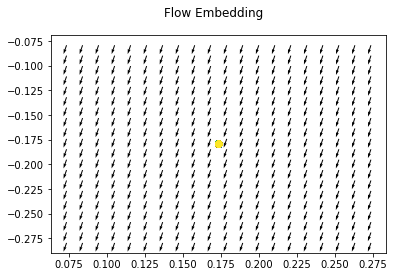

  0%|▏                                      | 1/300 [00:03<19:45,  3.96s/it]

{'reconstruction': tensor(0.4318, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


  3%|█▎                                    | 10/300 [00:38<18:21,  3.80s/it]

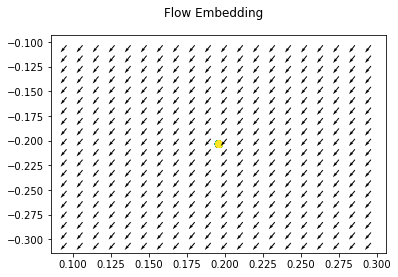

  4%|█▍                                    | 11/300 [00:42<18:32,  3.85s/it]

{'reconstruction': tensor(0.3886, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


  7%|██▌                                   | 20/300 [01:15<17:25,  3.74s/it]

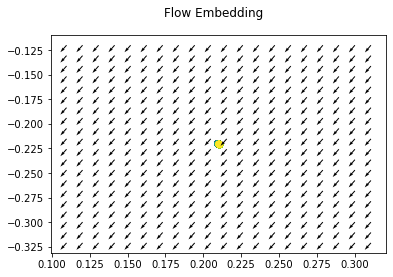

  7%|██▋                                   | 21/300 [01:19<17:36,  3.79s/it]

{'reconstruction': tensor(0.3427, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 10%|███▊                                  | 30/300 [01:52<16:37,  3.69s/it]

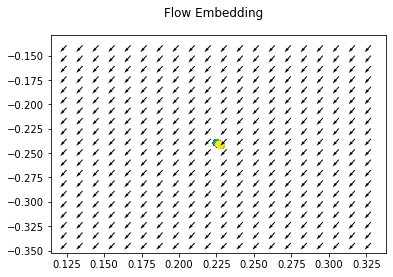

 10%|███▉                                  | 31/300 [01:56<16:49,  3.75s/it]

{'reconstruction': tensor(0.3587, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 13%|█████                                 | 40/300 [02:30<16:04,  3.71s/it]

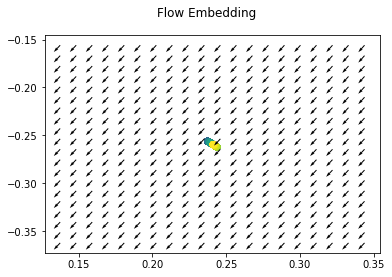

 14%|█████▏                                | 41/300 [02:34<16:13,  3.76s/it]

{'reconstruction': tensor(0.3264, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 17%|██████▎                               | 50/300 [03:07<15:40,  3.76s/it]

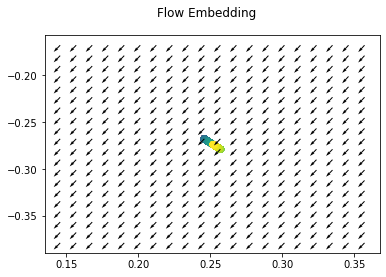

 17%|██████▍                               | 51/300 [03:11<16:01,  3.86s/it]

{'reconstruction': tensor(0.3453, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 20%|███████▌                              | 60/300 [03:47<15:46,  3.95s/it]

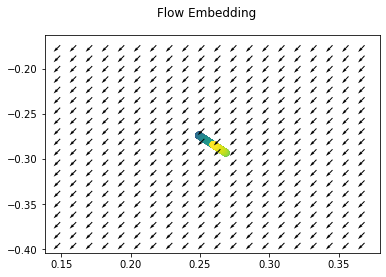

 20%|███████▋                              | 61/300 [03:51<15:49,  3.97s/it]

{'reconstruction': tensor(0.3314, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 23%|████████▊                             | 70/300 [04:25<14:50,  3.87s/it]

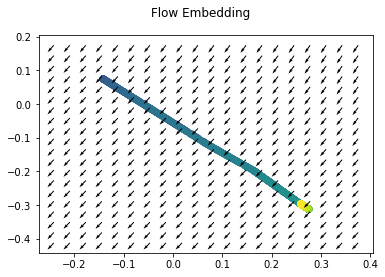

 24%|████████▉                             | 71/300 [04:30<15:03,  3.94s/it]

{'reconstruction': tensor(0.3335, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4657, grad_fn=<NllLossBackward0>)}


 27%|██████████▏                           | 80/300 [05:04<13:46,  3.76s/it]

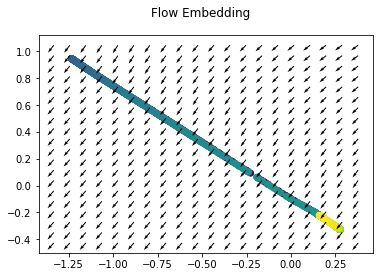

 27%|██████████▎                           | 81/300 [05:07<13:55,  3.81s/it]

{'reconstruction': tensor(0.3215, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4656, grad_fn=<NllLossBackward0>)}


 30%|███████████▍                          | 90/300 [05:41<13:13,  3.78s/it]

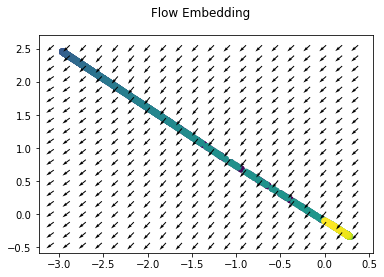

 30%|███████████▌                          | 91/300 [05:45<13:18,  3.82s/it]

{'reconstruction': tensor(0.2786, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4645, grad_fn=<NllLossBackward0>)}


 33%|████████████▎                        | 100/300 [06:20<12:42,  3.81s/it]

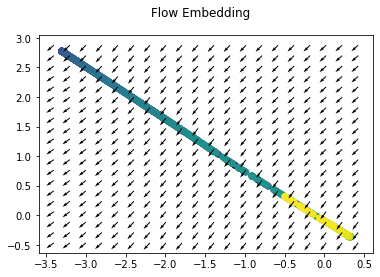

 34%|████████████▍                        | 101/300 [06:23<12:47,  3.86s/it]

{'reconstruction': tensor(0.2353, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4658, grad_fn=<NllLossBackward0>)}


 37%|█████████████▌                       | 110/300 [06:58<12:09,  3.84s/it]

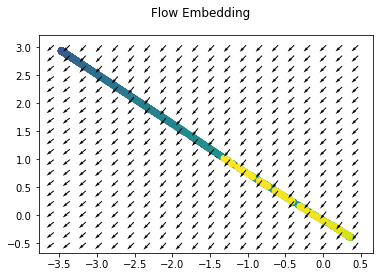

 37%|█████████████▋                       | 111/300 [07:02<12:18,  3.91s/it]

{'reconstruction': tensor(0.2460, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4617, grad_fn=<NllLossBackward0>)}


 40%|██████████████▊                      | 120/300 [07:36<11:22,  3.79s/it]

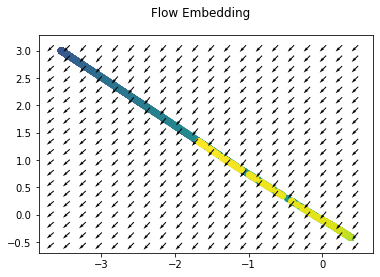

 40%|██████████████▉                      | 121/300 [07:40<11:26,  3.83s/it]

{'reconstruction': tensor(0.1869, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4629, grad_fn=<NllLossBackward0>)}


 43%|████████████████                     | 130/300 [08:14<10:49,  3.82s/it]

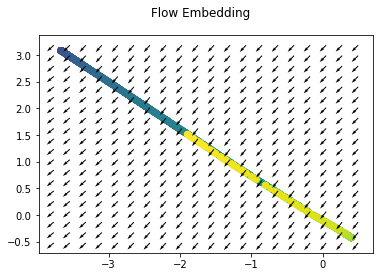

 44%|████████████████▏                    | 131/300 [08:18<10:49,  3.84s/it]

{'reconstruction': tensor(0.1819, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4587, grad_fn=<NllLossBackward0>)}


 47%|█████████████████▎                   | 140/300 [08:52<09:59,  3.75s/it]

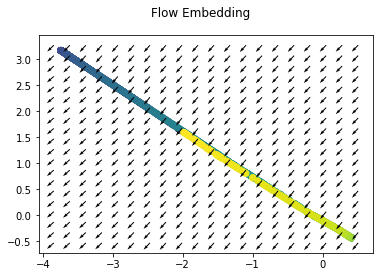

 47%|█████████████████▍                   | 141/300 [08:56<10:12,  3.85s/it]

{'reconstruction': tensor(0.1597, grad_fn=<MseLossBackward0>), 'contrastive loss': tensor(3.4674, grad_fn=<NllLossBackward0>)}


 50%|██████████████████▌                  | 150/300 [09:31<09:31,  3.81s/it]


KeyboardInterrupt: 

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=300)

# Results

In [ ]:
FREDtrainer.visualize_embedding(use_streamlines=True)

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
flow_artist = FREDtrainer.flow_artist

In [ ]:
# from FRED import embed
# from FRED.trainers import visualize_points
# visualize_points(FREDtrainer.embedded_points.cpu().detach(), FREDtrainer.flow_artist, labels = labels, use_streamlines=True)

In [ ]:
from FRED.embed import compute_grid
fig = plt.figure(dpi=200, figsize=(5,5))
ax = fig.add_subplot()
grid_width = 100
minx = float(np.min(embedded_points[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(embedded_points[:, 0]) + 0.1)
miny = float(np.min(embedded_points[:, 1]) - 0.1)
maxy = float(np.max(embedded_points[:, 1]) + 0.1)
x = np.linspace(minx, maxx, grid_width)
y = np.linspace(miny, maxy, grid_width)
# build grid points
Xgrid, Ygrid = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(Xgrid[:,:,None]), torch.tensor(Ygrid[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# pass grid through flow artist
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu()
v = uv[:,:, 1].cpu()
sc = ax.scatter(
    embedded_points[:, 0],
    embedded_points[:, 1],
    c=labels, cmap='viridis'
)
ax.streamplot(x,y,u,v)
plt.axis("off")
# Display all open figures.
plt.show()
plt.close()

In [ ]:
X.shape

In [ ]:
from FRED.embed import compute_grid
import plotly.figure_factory as ff
import numpy as np
import plotly.graph_objects as go
grid_width=200
# grid, x, y = compute_grid(embedded_points.to(device), return_unmeshed_x_and_y=True, grid_width=100)
minx = float(np.min(X[:, 0]) - 0.1)  # TODO: use torch.min, try without detach
maxx = float(np.max(X[:, 0]) + 0.1)
miny = float(np.min(X[:, 1]) - 0.1)
maxy = float(np.max(X[:, 1]) + 0.1)
x = np.linspace(-minx, maxx, grid_width)
y = np.linspace(-miny, maxy, grid_width)
X, Y = np.meshgrid(x, y)
xy_t = torch.concat([torch.tensor(X[:,:,None]), torch.tensor(Y[:, :, None])], dim=2).float()
# xy_t = xy_t.reshape(grid_width**2, 2).detach()
# controls the x and y axes of the plot
# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
# u = -1 - grid[:,0]**2 + grid[:,1]
# v = 1 + grid[:,0] - grid[:,1]**2
# u = -1 - X**2 + Y
# v = 1 + X - Y**2
uv = flow_artist(xy_t).detach().cpu()
u = uv[:,:, 0].cpu().numpy()
v = uv[:,:, 1].cpu().numpy()
# x = x.numpy()
# y = y.numpy()
# u = u.numpy()
# v = v.numpy()

In [ ]:
uv[:,:,0]

In [ ]:
v

In [ ]:
FREDtrainer.visualize_loss(loss_type='all')

In [ ]:
FREDtrainer.visualize_loss(loss_type='contrastive loss')

In [ ]:
FREDtrainer.training_gif(duration=150)

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()
points_and_flows = np.concatenate([embedded_points, embedded_velocities], axis=1)
points_and_flows.shape

In [ ]:
import sklearn 
silhouette_points = sklearn.metrics.silhouette_score(embedded_points, labels)
silhouette_points_and_flows = sklearn.metrics.silhouette_score(points_and_flows, labels)

## Nearest Neighbors Classifier Score

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(points_and_flows, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClass = KNeighborsClassifier(n_neighbors=3)
neighClass.fit(X_train, y_train)
knn_classifier_score = neighClass.score(X_test, y_test)

In [ ]:
print(f"## SCORES ## \n silhouette score w/o flows: {silhouette_points}.\n silhouette score w/ flows:  {silhouette_points_and_flows} \n kNN Classifier {knn_classifier_score}")

# Write results to spreadsheet

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
unid

In [ ]:
import csv
spread_name = notebook
with open(f"{spread_name}.csv", 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(
        [unid, 
         sigma, 
         flow_strength, 
         flow_neighbor_loss_weight,
         smoothness_weight, 
         diffdist_weight, 
         silhouette_points,
         silhouette_points_and_flows,
         knn_classifier_score
        ]) 